# Projet 5: Notebook pour la fréquence de maintenance

La ligne qui suit correspond à l'importation d'une librairie permettant la correction en imposant les règles pour suivre la programmation PEP8

In [1]:
%load_ext lab_black

Importation des librairies et du dataset

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
data = pd.read_csv("Dataset_joined.csv")

In [5]:
data.head()

,order_id,customer_unique_id,cat_mode_order,total_weight_order,volume_totat_order_cm3,price,pourcentage_livraison,nb_article,heure_commande,temps_commande_reception,order_purchase_timestamp,nombre_review_commande,review_score,semaine_vs_weekend,cat_creneautravailoupas,Distance_cust_seller_km,geolocation_lat_sellers,geolocation_lng_sellers,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,consommable,500.0,1976.0,29.99,0.225265,1,10,8.0,2017-10-02 10:56:33,1.0,4.0,jour_travail,temps_prof,0.000000,-23.155308,-47.084074,Est
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,consommable,400.0,4693.0,118.70,0.160894,1,20,13.0,2018-07-24 20:41:37,1.0,4.0,jour_travail,temps_perso,1375.789636,-13.049361,-39.560649,Nord_Est
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,service_outils,420.0,9576.0,159.90,0.107302,1,8,9.0,2018-08-08 08:38:49,1.0,5.0,jour_travail,temps_perso,768.269422,-16.577645,-49.334195,Ouest
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,consommable,450.0,6000.0,45.00,0.376731,1,19,13.0,2017-11-18 19:28:06,1.0,5.0,weekend,temps_perso,1804.635910,-5.856702,-35.990079,Nord_Est
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,multimedia,250.0,11475.0,19.90,0.304682,1,21,2.0,2018-02-13 21:18:39,1.0,5.0,jour_travail,temps_perso,0.000000,-23.155308,-47.084074,Est


In [9]:
data.order_purchase_timestamp = data.order_purchase_timestamp.apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)

In [27]:
start, end = data.order_purchase_timestamp.min(), data.order_purchase_timestamp.max()

In [29]:
print("Le jeu de données débute le", start, " et termine le", end)

Le jeu de données débute le 2016-09-15 12:16:38  et termine le 2018-08-29 15:00:37


On va prendre la première année afin de pouvoir simuler un modèle que nous donnerions à la société. On aura donc le reste pour effectuer les différents entraînement pour analyser la dérive.

In [32]:
pd.date_range(start, end, freq="MS")[:13]

DatetimeIndex(['2016-10-01 12:16:38', '2016-11-01 12:16:38',
               '2016-12-01 12:16:38', '2017-01-01 12:16:38',
               '2017-02-01 12:16:38', '2017-03-01 12:16:38',
               '2017-04-01 12:16:38', '2017-05-01 12:16:38',
               '2017-06-01 12:16:38', '2017-07-01 12:16:38',
               '2017-08-01 12:16:38', '2017-09-01 12:16:38',
               '2017-10-01 12:16:38'],
              dtype='datetime64[ns]', freq='MS')

In [39]:
diff_date_int = pd.date_range(start, end, freq="MS")[13:]

In [120]:
date_init = pd.date_range(start, end, freq="MS")[12]
date_init

Timestamp('2017-10-01 12:16:38', freq='MS')

Création de la base de données dfinit qui entrainera le modèle donné au client:

In [50]:
data_init = data[(data.order_purchase_timestamp < date_init)]

In [51]:
df_init = data_init.groupby("customer_unique_id").agg(
    {
        "Distance_cust_seller_km": "mean",
        "review_score": "mean",
        "temps_commande_reception": "mean",
        "pourcentage_livraison": "mean",
        "price": "mean",
    }
)

In [55]:
print(
    "Sur la première année, on va entrainer le modèle avec {} clients".format(
        len(df_init)
    )
)

Sur la première année, on va entrainer le modèle avec 25230 clients


In [57]:
scaler = StandardScaler()

In [58]:
df_init_scaled = scaler.fit_transform(df_init)

In [81]:
model_init = KMeans(4, random_state=42)

In [82]:
model_init.fit(df_init_scaled)

KMeans(n_clusters=4, random_state=42)

In [83]:
pd.DataFrame(model_init.labels_).value_counts()

2    16315
3     4145
0     4036
1      734
dtype: int64

In [84]:
analyse = df_init.copy()

In [85]:
analyse["cluster"] = model_init.labels_

In [86]:
analyse.groupby("cluster").apply(lambda x: x.mean())

,Distance_cust_seller_km,review_score,temps_commande_reception,pourcentage_livraison,price,cluster
cluster,,,,,,
0,416.764352,2.012017,13.245210,0.204320,118.449834,0.0
1,826.153985,4.308902,13.635559,0.052496,1070.753903,1.0
2,335.959864,4.753575,9.266585,0.189159,112.498856,2.0
3,1610.434997,4.354394,19.520989,0.319487,96.401526,3.0


In [75]:
taille_lst = [len(df_init)]
ARI_list = []

for date in diff_date_int:
    df_k = (
        data[(data.order_purchase_timestamp < date)]
        .groupby("customer_unique_id")
        .agg(
            {
                "Distance_cust_seller_km": "mean",
                "review_score": "mean",
                "temps_commande_reception": "mean",
                "pourcentage_livraison": "mean",
                "price": "mean",
            }
        )
    )

    taille_lst.append(len(df_k))

Text(0.5, 1.0, 'Evolution de la taille des dataset par ajout de mois')

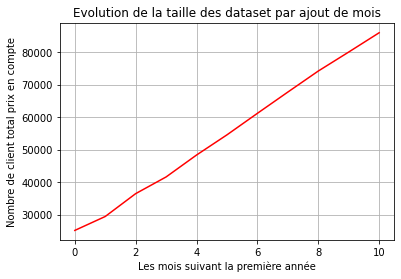

In [79]:
plt.plot(taille_lst, color="red")
plt.grid()
plt.xlabel("Les mois suivant la première année")
plt.ylabel("Nombre de client total prix en compte")
plt.title("Evolution de la taille des dataset par ajout de mois")

In [106]:
adjusted_rand_score(
    model_init.predict(df_init_scaled), model_init.predict(df_init_scaled)
)

1.0

In [107]:
ARI_list_ = [
    adjusted_rand_score(
        model_init.predict(df_init_scaled), model_init.predict(df_init_scaled)
    )
]
centroid_evol_list = [model_init.cluster_centers_]

for date in diff_date_int:
    df_k = (
        data[(data.order_purchase_timestamp < date)]
        .groupby("customer_unique_id")
        .agg(
            {
                "Distance_cust_seller_km": "mean",
                "review_score": "mean",
                "temps_commande_reception": "mean",
                "pourcentage_livraison": "mean",
                "price": "mean",
            }
        )
    )
    df_k_scaled = scaler.transform(df_k)
    model_k = KMeans(4, random_state=42)
    model_k.fit(df_k_scaled)
    centroid_evol_list.append(model_k.cluster_centers_)

    ARI_list_.append(
        adjusted_rand_score(
            model_k.predict(df_k_scaled), model_init.predict(df_k_scaled)
        )
    )

In [94]:
centroid_evol_list

[array([[-0.24548607, -1.86971295,  0.16423676, -0.03820805, -0.08832439],
        [ 0.40197439,  0.06049867,  0.20623116, -1.24366277,  4.07154601],
        [-0.37301882,  0.43461986, -0.26263969, -0.15884521, -0.11427089],
        [ 1.63204984,  0.09932076,  0.83520111,  0.88094161, -0.18607803]]),
 array([[-0.4148453 ,  0.38797506, -0.29222954, -0.2922653 , -0.08825655],
        [-0.06593567, -2.01648416,  0.43399068,  0.01511012, -0.08143439],
        [ 0.45501897,  0.07148298,  0.18559883, -1.23119973,  3.90898309],
        [ 1.20512792,  0.24168545,  0.51314786,  1.01994228, -0.25942113]]),
 array([[ 0.40368551,  0.07852822,  0.19044798, -1.22556199,  3.77208908],
        [-0.42639443,  0.33253795, -0.26401916, -0.32299501, -0.08440752],
        [ 0.05975565, -2.20976972,  0.91621625,  0.02205723, -0.05178477],
        [ 1.03992905,  0.25529283,  0.39910442,  1.03814423, -0.28584177]]),
 array([[ 5.39892074e-02, -2.21393107e+00,  1.00013964e+00,
          1.64384885e-03, -3.97406

In [108]:
len(ARI_list_)

11

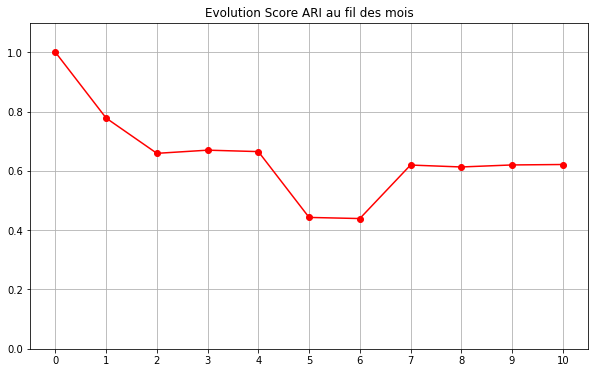

In [117]:
df = pd.DataFrame({"Mois comptés en +": range(0, 11), "ARI score": ARI_list_})

plt.figure(figsize=(10, 6))

plt.plot(
    "Mois comptés en +", "ARI score", data=df, linestyle="-", marker="o", color="red"
)
plt.grid()
plt.ylim(0, 1.1)
plt.xticks(np.arange(0, 11))
plt.title("Evolution Score ARI au fil des mois")
plt.show()

In [87]:
model_init.predict(df_init_scaled)

array([0, 2, 3, ..., 1, 3, 2])

In [156]:
ARI_list_2 = [
    adjusted_rand_score(
        model_init.predict(df_init_scaled), model_init.predict(df_init_scaled)
    )
]
centroid_evol_list_2 = [model_init.cluster_centers_]

for date in diff_date_int:
    df_k = (
        data[(data.order_purchase_timestamp < date)]
        .groupby("customer_unique_id")
        .agg(
            {
                "Distance_cust_seller_km": "mean",
                "review_score": "mean",
                "temps_commande_reception": "mean",
                "pourcentage_livraison": "mean",
                "price": "mean",
            }
        )
    )
    scaler_k = StandardScaler()
    df_k_scaled = scaler_k.fit_transform(df_k)
    model_k = KMeans(4, random_state=42)
    model_k.fit(df_k_scaled)
    centroid_evol_list.append(model_k.cluster_centers_)

    ARI_list_2.append(
        adjusted_rand_score(
            model_k.predict(df_k_scaled), model_init.predict(scaler.transform(df_k))
        )
    )

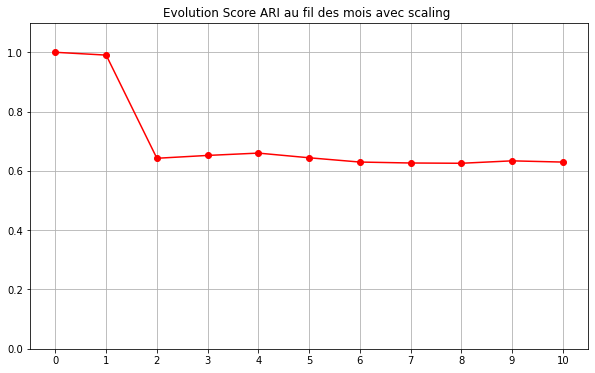

In [157]:
df = pd.DataFrame({"Mois comptés en +": range(0, 11), "ARI score": ARI_list_2})

plt.figure(figsize=(10, 6))

plt.plot(
    "Mois comptés en +", "ARI score", data=df, linestyle="-", marker="o", color="red"
)
plt.grid()
plt.ylim(0, 1.1)
plt.xticks(np.arange(0, 11))
plt.title("Evolution Score ARI au fil des mois avec scaling ")
plt.show()

Essayons avec les semaines 

In [143]:
date_init_w = pd.date_range(start, end, freq="w")[54]
diff_date_int_weekly = pd.date_range(start, end, freq="w")[55:]

In [170]:
ARI_list_weekly = []
centroid_evol_list_weekly = [model_init.cluster_centers_]
shape_len = [len(df_init)]
for date in diff_date_int_weekly:
    df_k = (
        data[(data.order_purchase_timestamp < date)]
        .groupby("customer_unique_id")
        .agg(
            {
                "Distance_cust_seller_km": "mean",
                "review_score": "mean",
                "temps_commande_reception": "mean",
                "pourcentage_livraison": "mean",
                "price": "mean",
            }
        )
    )
    scaler_weeklyk = StandardScaler()
    df_k_scaled = scaler_weeklyk.fit_transform(df_k)
    shape_len.append(len(df_k))
    model_k = KMeans(4, random_state=42)
    model_k.fit(df_k_scaled)
    centroid_evol_list.append(model_k.cluster_centers_)

    ARI_list_weekly.append(
        adjusted_rand_score(
            model_k.predict(df_k_scaled), model_init.predict(scaler.transform(df_k))
        )
    )

In [146]:
len(ARI_list_weekly)

47

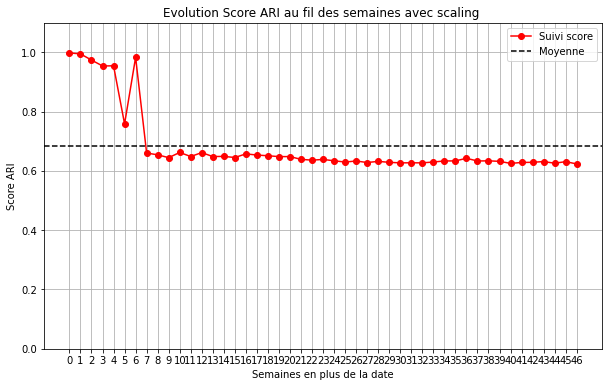

In [165]:
df = pd.DataFrame({"Mois comptés en +": range(0, 47), "ARI score": ARI_list_weekly})

plt.figure(figsize=(10, 6))

plt.plot(
    "Mois comptés en +",
    "ARI score",
    data=df,
    linestyle="-",
    marker="o",
    color="red",
    label="Suivi score",
)
plt.axhline(
    y=np.mean(ARI_list_weekly),
    linestyle="--",
    color="black",
    label="Moyenne",
)

plt.grid()
plt.ylim(0, 1.1)
plt.xlabel("Semaines en plus de la date")
plt.ylabel("Score ARI")
plt.legend()
plt.title("Evolution Score ARI au fil des semaines avec scaling ")
plt.show()

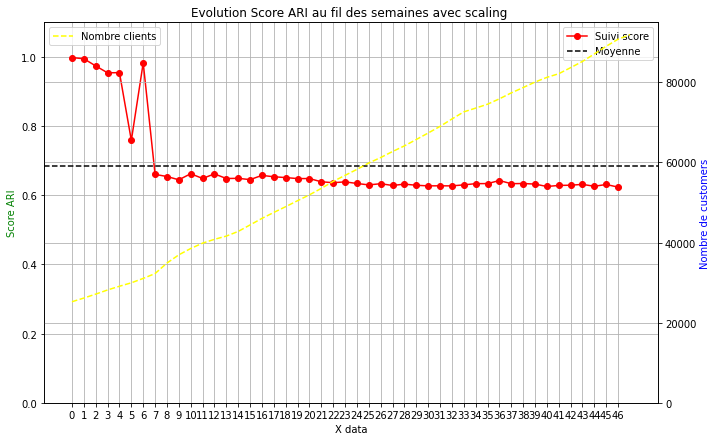

In [188]:
fig, ax1 = plt.subplots(figsize=(11, 7))

ax2 = ax1.twinx()
ax1.plot(
    "Mois comptés en +",
    "ARI score",
    data=df,
    linestyle="-",
    marker="o",
    color="red",
    label="Suivi score",
)
ax1.axhline(
    y=np.mean(ARI_list_weekly),
    linestyle="--",
    color="black",
    label="Moyenne",
)
ax2.plot(shape_len, color="yellow", linestyle="--", label="Nombre clients")

ax1.set_xlabel("X data")
ax1.set_ylabel("Score ARI", color="g")
ax2.set_ylabel("Nombre de customers", color="b")
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 95000)

plt.title("Evolution Score ARI au fil des semaines avec scaling ")
plt.xticks(np.arange(0, 47))
ax1.grid(which="both")
ax2.grid(which="both")

ax1.legend()
ax2.legend()
plt.show()

In [168]:
df_init.describe()

,Distance_cust_seller_km,review_score,temps_commande_reception,pourcentage_livraison,price
count,25230.000000,25230.000000,25230.000000,25230.000000,25230.000000
mean,572.528585,4.236495,11.714824,0.209020,138.684108
std,634.567678,1.189898,9.329288,0.125714,228.786756
min,0.000000,1.000000,0.000000,0.000000,2.290000
25%,0.000000,4.000000,7.000000,0.117953,45.900000
50%,426.472203,5.000000,10.000000,0.183256,84.990000
75%,821.913063,5.000000,14.000000,0.274545,149.990000
max,3310.827734,5.000000,209.000000,0.851621,13440.000000


In [169]:
pd.DataFrame(df_init_scaled, columns=df_init.columns).describe()

,Distance_cust_seller_km,review_score,temps_commande_reception,pourcentage_livraison,price
count,2.523000e+04,2.523000e+04,2.523000e+04,2.523000e+04,2.523000e+04
mean,-3.434519e-17,-2.115232e-15,4.518339e-17,1.911683e-16,1.483290e-16
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-9.022520e-01,-2.720031e+00,-1.255729e+00,-1.662697e+00,-5.961744e-01
25%,-9.022520e-01,-1.987567e-01,-5.053887e-01,-7.244145e-01,-4.055565e-01
50%,-2.301713e-01,6.416682e-01,-1.838144e-01,-2.049447e-01,-2.346953e-01
75%,3.930068e-01,6.416682e-01,2.449513e-01,5.212378e-01,4.941770e-02
max,4.315306e+00,6.416682e-01,2.114728e+01,5.111717e+00,5.813964e+01
